# Задание 1. A/B–тестирование

# Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from tqdm.auto import tqdm
from scipy.stats import chi2_contingency
from scipy.stats import norm
from matplotlib.ticker import PercentFormatter

# Загрузка данных

In [2]:
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-anna-perepecha-etp-cdb76/Final_project/Проект_2_active_studs.csv', sep = ';')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-anna-perepecha-etp-cdb76/Final_project/Проект_2_checks.csv', sep = ';')
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-anna-perepecha-etp-cdb76/Final_project/Проект_2_group_add.csv')
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-anna-perepecha-etp-cdb76/Final_project/Проект_2_groups.csv', sep = ';')

# Анализ данных

Проверим данные на наличие дубликатов и пустых значений.

In [3]:
# проверка данных на наличие дубликатов

print(active_studs.duplicated().sum(), 
      checks.duplicated().sum(),
      groups_add.duplicated().sum(),
      groups.duplicated().sum())

0 0 0 0


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
# проверка данных на наличие пустых значений
print(active_studs.isnull().sum(), 
      checks.isnull().sum(),
      groups_add.isnull().sum(),
      groups.isnull().sum())

student_id    0
dtype: int64 student_id    0
rev           0
dtype: int64 id     0
grp    0
dtype: int64 id     0
grp    0
dtype: int64


Дубликатов строк и пустых значений не выявлено.

Для дальнейшего анализа, единообразно переименуем колонки, а также объединим информацию в таблицы.

In [5]:
# переименуем колонку с id студентов в таблицax active_studs и checks

active_studs = active_studs.rename(columns = {'student_id':'id'})
checks = checks.rename(columns = {'student_id':'id'})

In [6]:
# объединим данные таблиц groups и groups_add и создадим общую таблицу с названием groups_all

groups_all = pd.concat([groups, groups_add], axis = 0)
groups_all.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
# проверим, что после объединения не возникло дублирующих строк

groups_all.duplicated().sum()

0

In [8]:
# объединим информацию по активным студентам в одну таблицу и выведем информацию о таблице

active_studs_by_group = active_studs.merge(groups_all, on = 'id', how = 'left')\
                                    .merge(checks, on = 'id', how = 'left')
active_studs_by_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8341 non-null   object 
 2   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [9]:
# выведим информацию по таблице checks

checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Мы видим, что получившееся в объединенной таблице количество активных пользователей, оплативших услугу составляет 392 чел., в то время как общее количество пользователей, оплативших услугу - 541. Т.е. пользователю не обязательно быть активным, чтобы оплатить услугу.

In [10]:
# заменим пропущенные значения в таблице active_studs_by_group на 0

active_studs_by_group = active_studs_by_group.fillna(0)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Пункт 1.1. Выбор метрик для анализа.
Для анализа будем использовать следующие метрики:

**1. Конверсия в платящего пользователя (CR).**

Определение: Количество пользователей, которые оплатили услугу / Количество пользователей, которые посетили платформу.

Цель: Оценить, изменилась ли конверсия в оплату у экспериментальной группы пользователей, которым была предложена новая механика оплаты.

**2. Средняя выручка на одного платящего пользователя (ARPPU).**

Определение: Общая сумма выручки /  Количество пользователей, которые оплатили услугу.

Цель: Оценить, изменилась ли средняя выручка на одного платящего пользователя из экспериментальной группы.

**3. Средняя выручка на одного пользователя (ARPU).**

Определение: Общая сумма выручки /  Количество пользователей.

Цель: Оценить, насколько значительная доля пользователей генерирует доход в контрольной и экспериментальной группах.

На основании данных метрик проанализируем итоги эксперимента и сделаем вывод, стоит ли запускать новую механику оплаты на всех пользователей.


# Пункт 1.2. Оценить различия в показателях и с чем они могут быть связаны.

In [11]:
# подготовим таблицу с данными о выручке и количестве пользователей в разрезе групп

metrics = active_studs_by_group.groupby('grp', as_index = False)\
                               .agg(count_all = ('id','count'), count_rev = ('rev', lambda x: x[x>0].count()), revenue = ('rev', 'sum'))
metrics

,grp,count_all,count_rev,revenue
0,A,1538,78.0,72820.0000
1,B,6803,314.0,394974.0035


In [12]:
# рассчитаем метрики и добавим их в таблицу metrics

metrics['CR'] = round(metrics.count_rev / metrics.count_all*100, 2)
metrics['ARPPU'] = round(metrics.revenue / metrics.count_rev, 2)
metrics['ARPU'] = round(metrics.revenue / metrics.count_all, 2)

metrics

,grp,count_all,count_rev,revenue,CR,ARPPU,ARPU
0,A,1538,78.0,72820.0000,5.07,933.59,47.35
1,B,6803,314.0,394974.0035,4.62,1257.88,58.06


Из полученной таблицы с метриками мы видим, что у целевой группы конверсия в оплату ниже, при этом выручка на одного пользователя - выше. Это может быть связано с тем, что количество пользователей в группах А и В существенно различается.
Для того, чтобы сделать вывод, проверим статистическую значимость различий.


# Пункт 1.3. Оценить, являются ли различия в показателях статистически значимыми.

### Проверка данных на нормальность распределения

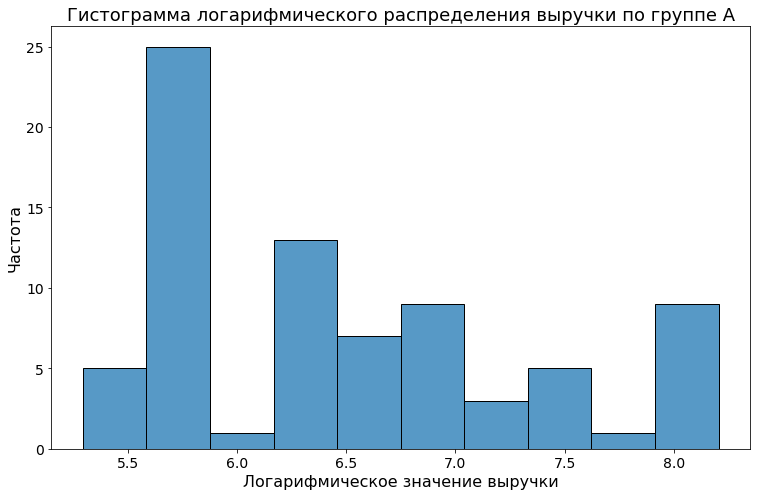

In [13]:
#построим гистограмму распределению выручки по группе А с использованием логарифма

plt.figure(figsize = (11,7))
sns.histplot(data = np.log(active_studs_by_group.query('rev>0 & grp == "A"').rev), bins=10)
plt.title('Гистограмма логарифмического распределения выручки по группе А', fontsize = 18)
plt.xlabel('Логарифмическое значение выручки', fontsize = 16)
plt.ylabel('Частота', fontsize = 16)
plt.tick_params(axis='both', labelsize=14) 
plt.tight_layout()
plt.show()

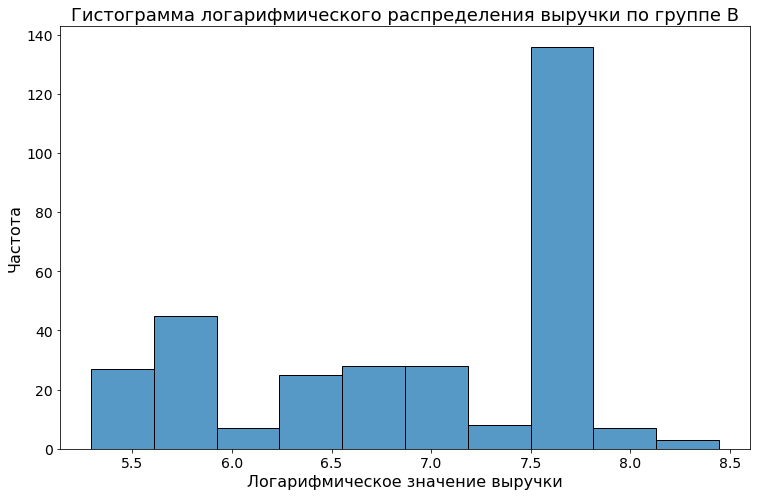

In [14]:
#построим гистограмму распределению выручки по группе B с использованием логарифма

plt.figure(figsize = (11,7))
sns.histplot(data = np.log(active_studs_by_group.query('rev>0 & grp == "B"').rev), bins=10)
plt.title('Гистограмма логарифмического распределения выручки по группе B', fontsize = 18)
plt.xlabel('Логарифмическое значение выручки', fontsize = 16)
plt.ylabel('Частота', fontsize = 16)
plt.tick_params(axis='both', labelsize=14) 
plt.tight_layout()
plt.show()

In [15]:
# дополнительно проверим распределение данных на нормальность с помощью теста Д'Агостино-Пирсона

pg.normality(data=active_studs_by_group, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,2240.595797,0.0,False
B,7797.399212,0.0,False


На основании полученных графиков и теста на нормальность можно сделать вывод, что данные распределены не нормально.

### Проверка данных на наличие аномальных выбросов в распределениях

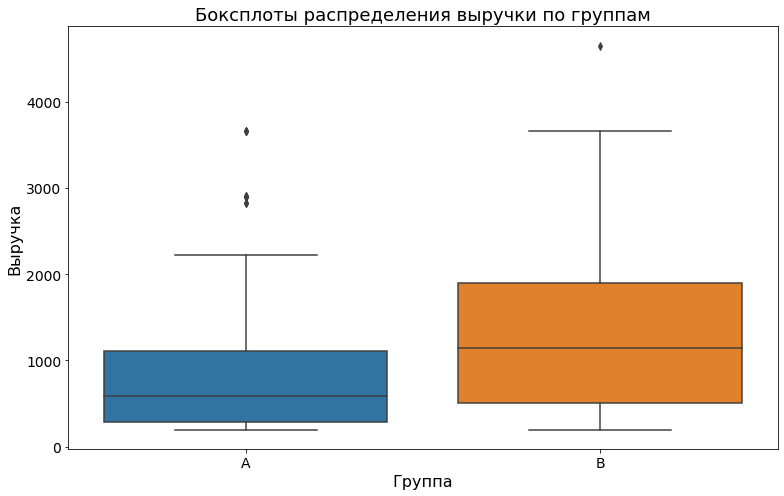

In [16]:
plt.figure(figsize = (11,7))
sns.boxplot(data = active_studs_by_group[active_studs_by_group.rev > 0],  x = 'grp', y = 'rev')
plt.title('Боксплоты распределения выручки по группам', fontsize = 18)
plt.xlabel('Группа', fontsize = 16)
plt.ylabel('Выручка', fontsize = 16)
plt.tick_params(axis='both', labelsize=14) 
plt.tight_layout()
plt.show()

На основании данных боксплотов можно сделать вывод о том, что аномальные выбросы есть как в группе А, так и в группе В.

### Проверка равенства дисперсий

In [36]:
# проверим равенство дисперсий с помощью теста Левена

pg.homoscedasticity(data=active_studs_by_group, dv="rev", group="grp", method='levene')

,W,pval,equal_var
levene,1.501461,0.220481,True


На основании теста на равенство дисперсий, мы можем сделать вывод о равенстве дисперсий.

Таким образом, для проверки статической значимости различий будем использовать критерий хи-квадрат (для метрики CR) и бутстрап (для метрик ARPPU, ARPU). 

В данном случае, использование бутстрап обосновано тем, что данные распределены не нормально, есть аномальные выбросы в обеих группах, а также размеры выборок значительно различаются (более, чем в 4 раза). Использование t-теста также возможно, поскольку нормальность распределения для него не критична (особенно при большом объеме выборок, ≥30) и дисперсии в группах равны, однако наличие выбросов может сильно исказить полученные результаты. Поэтому для использования t-теста лучше предварительно избавиться от выбросов, если такой подход возможен.

# Проверка для CR

H0: Конверсия в платящего пользователя не отличается между группами.

H1: Конверсия в платящего пользователя отличается между группами.

In [18]:
# создадим колонку, определяющую к какой группе относится пользователь (к платящей или не платящей)

active_studs_by_group['paying'] = active_studs_by_group.rev > 0

In [19]:
# построим таблицу сопряженности

cr_crosstab = pd.crosstab(active_studs_by_group.grp, active_studs_by_group.paying)
cr_crosstab

paying,False,True
grp,,
A,1460,78
B,6489,314


In [20]:
# применение теста хи-квадрат

chi2, p, dof, expected = chi2_contingency(cr_crosstab)

print(f"Chi2 статистика: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Степени свободы: {dof}")
print("Ожидаемые частоты:")
print(expected)

Chi2 статистика: 0.4848
P-value: 0.4863
Степени свободы: 1
Ожидаемые частоты:
[[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


Поскольку значение p-value составляет 0.4863, мы не можем отвергнуть нулевую гипотезу на уровне значимости 0.05.

# Проверка для ARPPU

H0: Средняя выручка на одного платящего пользователя (ARPPU) не отличается между группами.

H1: Средняя выручка на одного платящего пользователя (ARPPU) отличается между группами.

In [21]:
'''Напишем функцию, которая позволит проверить гипотезы с помощью бутстрапа.
   
   Данная функция осуществляет бутстрап-проверку разницы между двумя числовыми выборками (data_column_1 и data_column_2), 
   используя заданную статистику (по умолчанию — среднее). 
   Она создает много бутстрап-подвыборок, рассчитывает для каждой разницу значений статистики, 
   строит доверительный интервал и оценивает p-значение, а также отображает гистограмму распределения бутстрэп-подвыборок.
   
'''
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрап-подвыборок (по умолчанию: 1000)
    statistic = np.mean, # интересующее нас значение статистики (по умолчанию: np.mean)
    bootstrap_conf_level = 0.95 # уровень значимости для доверительных интервалов (по умолчанию: 0.95)
):
    
    boot_len = max([len(data_column_1), len(data_column_2)]) # определяем размер бутстрап-подвыборки как максимальный из размеров выборок (data_column_1, data_column_2), чтобы сохранить дисперсию
    boot_data = [] # создаем список, в который будем складывать рассчитанные статистики для каждой бутстрап-подвыборки
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = np.random.choice(data_column_1, #cоздаются бутстрап-выборки из оригинальных данных с возвратом
                    boot_len, 
                    replace = True) #параметр возвращения
    
        samples_2 = np.random.choice(data_column_2,
                    boot_len, # чтобы сохранить дисперсию берем такой же размер выборки
                    replace = True)
        
        boot_data.append(statistic(samples_1) - statistic(samples_2)) # вычисление разницы в статистиках для бутстрап-подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data) # создание DataFrame для хранения результатов
    
    left_quant = (1 - bootstrap_conf_level)/2 # задаем границы доверительного интервала по квантилям
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    
    # двухсторонний p-value при предполагаемом нормальном распределении
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2)*2
    
    
    # визуализация
    plt.figure(figsize = (11,7))
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    # результаты бутстрап-анализа в виде словаря с ключами "boot_data", "quants" и "p_value"
    return {"boot_data": boot_data, "quants": quants, "p_value": p_value} 

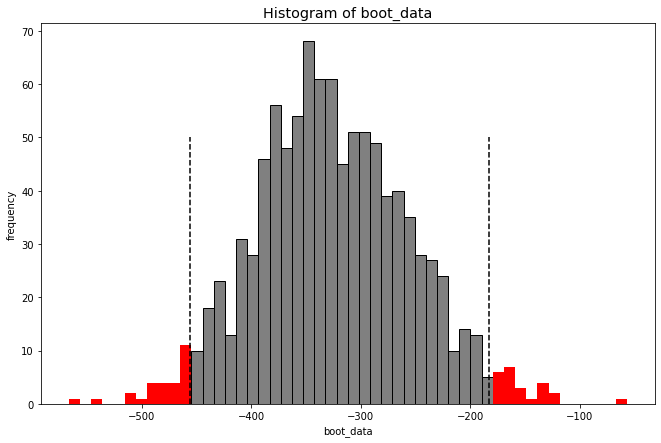

In [22]:
arppu_boot_data = get_bootstrap(active_studs_by_group.query('paying == True & grp == "A"').rev,
                                active_studs_by_group.query('paying == True & grp == "B"').rev)

In [23]:
# P-value

print(f"P-value: {arppu_boot_data['p_value']:.4f}")

P-value: 0.0000


In [24]:
# доверительный интервал

arppu_boot_data["quants"]

,0
0.025,-456.113466
0.975,-183.286395


Поскольку значение p-value составляет 0.0000 и доверительный интервал не включает в себя значение 0, мы можем отвергнуть нулевую гипотезу на уровне значимости 0.05.

# Проверка для ARPU

H0: Средняя выручка на одного пользователя (ARPU) не отличается между группами.

H1: Средняя выручка на одного пользователя (ARPU) отличается между группами.

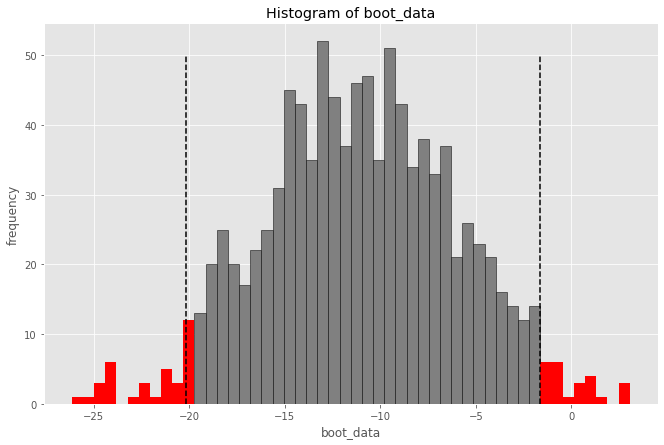

In [25]:
arpu_boot_data = get_bootstrap(active_studs_by_group.query('grp == "A"').rev,
                               active_studs_by_group.query('grp == "B"').rev)

In [26]:
# P-value

print(f"P-value: {arpu_boot_data['p_value']:.4f}")

P-value: 0.0266


In [27]:
# доверительный интервал

arpu_boot_data["quants"]

,0
0.025,-20.178264
0.975,-1.647178


Поскольку значение p-value составляет 0.0266 и доверительный интервал не включает в себя значение 0, мы можем отвергнуть нулевую гипотезу на уровне значимости 0.05.

# Пункт 1.4. Оценить, стоит ли запускать новую механику на всех пользователей.

На основании проведенного A/B тестирования мы видим, что все метрики (ARPU и ARPPU), кроме CR, у экспериментальной группы статистически значимо выросли.

В связи с этим, можем сделать вывод о том, что можно запустить новую механику на всех пользователей.

# Задание 2. SQL
# Пункт 2.1. Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица peas. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.
Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [ ]:
'''SELECT st_id, 
          COUNT(correct) AS correct_count 
     FROM peas
    WHERE correct = true
    GROUP BY st_id
   HAVING COUNT(correct) >= 20
    ORDER BY st_id;'''

По результатам данного запроса, было получено 136 очень усердных учеников.

# Пункт 2.2. Оптимизация воронки.

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Даны таблицы: peas, studs, final_project_check.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [ ]:
'''
-- таблица с данными об активных пользователях
WITH active_studs AS (SELECT p.st_id,  
                             COUNT(p.correct) AS correct_peas,
                             s.test_grp
                      FROM peas AS p
                      JOIN studs AS s
                        ON s.st_id = p.st_id
                      WHERE correct = true
                      GROUP BY p.st_id, s.test_grp
                      HAVING COUNT(p.correct) > 10),
                      
-- таблица с данными об активных пользователях по математике                     
active_studs_math AS (SELECT p.st_id, 
                             COUNT(p.correct) AS correct_peas,
                             s.test_grp,
                             p.subject
                      FROM peas AS p
                      JOIN studs AS s
                        ON s.st_id = p.st_id
                      WHERE correct = true AND subject = 'Math'
                      GROUP BY p.st_id, s.test_grp, p.subject
                      HAVING COUNT(correct) >= 2)
                           

-- объединенная таблица с рассчитанными метриками
SELECT s.test_grp, 
       SUM(fp.money) / COUNT(DISTINCT s.st_id) AS arpu,
       
       SUM(fp.money) / COUNT(DISTINCT a_s.st_id) AS arpau,
       
       (COUNT(DISTINCT fp.st_id)::FLOAT/ COUNT(DISTINCT s.st_id)::FLOAT)*100 AS cr,
       
       (COUNT(DISTINCT CASE WHEN a_s.st_id IS NOT NULL AND fp.st_id IS NOT NULL THEN a_s.st_id END)::FLOAT/ 
        COUNT(DISTINCT a_s.st_id)::FLOAT)*100 AS cr_active,
       
       (COUNT(DISTINCT CASE WHEN a_s_m.st_id IS NOT NULL AND fp.st_id IS NOT NULL AND fp.subject = 'Math' THEN a_s_m.st_id END)::FLOAT/ 
        COUNT(DISTINCT a_s_m.st_id)::FLOAT)*100 AS cr_math_active
       
 FROM studs AS s
 LEFT JOIN final_project_check AS fp
   ON s.st_id = fp.st_id
 LEFT JOIN active_studs AS a_s
   ON s.st_id = a_s.st_id
  LEFT JOIN active_studs_math AS a_s_m
   ON s.st_id = a_s_m.st_id
GROUP BY s.test_grp;
'''

# Задание 3. Python

# Пункт 3.1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [30]:
''' Создадим функцию для пересчета метрик (на основании решения, полученного по заданию 1).
    Данная функция получает на вход данные о группах, добавочных группах, активных студентах и оплатах.
    После чего, выполняется пересчет метрик и возращается результат в виде таблицы.
'''

def recalculation_metrics(groups, groups_add, active_studs, checks):
    
    # переименуем колонку с id студентов в таблицax active_studs и checks
    active_studs = active_studs.rename(columns = {'student_id':'id'})
    checks = checks.rename(columns = {'student_id':'id'})

    # объединим данные таблиц groups и groups_add и создадим общую таблицу с названием groups_all
    groups_all = pd.concat([groups, groups_add], axis = 0)

    # объединим информацию по активным студентам в одну таблицу
    active_studs_by_group = active_studs.merge(groups_all, on = 'id', how = 'left')\
                                        .merge(checks, on = 'id', how = 'left')

    # заменим пропущенные значения в таблице active_studs_by_group на 0
    active_studs_by_group = active_studs_by_group.fillna(0)

    # подготовим таблицу с данными о выручке и количестве пользователей в разрезе групп
    metrics = active_studs_by_group.groupby('grp', as_index = False)\
                                   .agg(count_all = ('id','count'), count_rev = ('rev', lambda x: x[x>0].count()), revenue = ('rev', 'sum'))

    # рассчитаем метрики и добавим их в таблицу metrics
    metrics['CR'] = round(metrics.count_rev / metrics.count_all*100, 2)
    metrics['ARPPU'] = round(metrics.revenue / metrics.count_rev, 2)
    metrics['ARPU'] = round(metrics.revenue / metrics.count_all, 2)
    
    return metrics

In [31]:
# результат функции

df_metrics = recalculation_metrics(groups, groups_add, active_studs, checks)
df_metrics

,grp,count_all,count_rev,revenue,CR,ARPPU,ARPU
0,A,1538,78.0,72820.0000,5.07,933.59,47.35
1,B,6803,314.0,394974.0035,4.62,1257.88,58.06


# Пункт 3.2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [32]:
''' Создадим функцию для построения графиков по получаемым метрикам.
    Данная функция получает на вход датафрейм с метриками.
    После чего, выполняется построение барчатов для каждой из метрик (CR, ARPPU, ARPU).
'''

def plot_metrics(df_metrics):
    
    df_metrics_sorted = df_metrics.sort_values(by='grp', ascending = False) 
    plt.figure(figsize = (11,7))
    
    # построение графика для CR
    plt.figure(figsize = (11,7))
    plt.barh(df_metrics_sorted['grp'], df_metrics_sorted['CR'], color='coral')
    plt.title('Конверсия в платящего пользователя (CR) по группам', fontsize = 18)
    plt.xlabel('CR', fontsize = 16)
    plt.ylabel('Группа', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14) 
    plt.gca().xaxis.set_major_formatter(PercentFormatter())
    plt.tight_layout()
    plt.show()
    
    # построение графика для ARPPU
    plt.figure(figsize = (11,7))
    plt.barh(df_metrics_sorted['grp'], df_metrics_sorted['ARPPU'], color='coral')
    plt.title('Средняя выручка на одного платящего пользователя (ARPPU) по группам', fontsize = 18)
    plt.xlabel('ARPPU', fontsize = 16)
    plt.ylabel('Группа', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14) 
    plt.tight_layout()
    plt.show()
    
    # построение графика для ARPU
    plt.figure(figsize = (11,7))
    plt.barh(df_metrics_sorted['grp'], df_metrics_sorted['ARPU'], color='coral')
    plt.title('Средняя выручка на одного пользователя (ARPU) по группам', fontsize = 18)
    plt.xlabel('ARPU', fontsize = 16)
    plt.ylabel('Группа', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14) 
    plt.tight_layout()
    plt.show()
    
    

<Figure size 792x504 with 0 Axes>

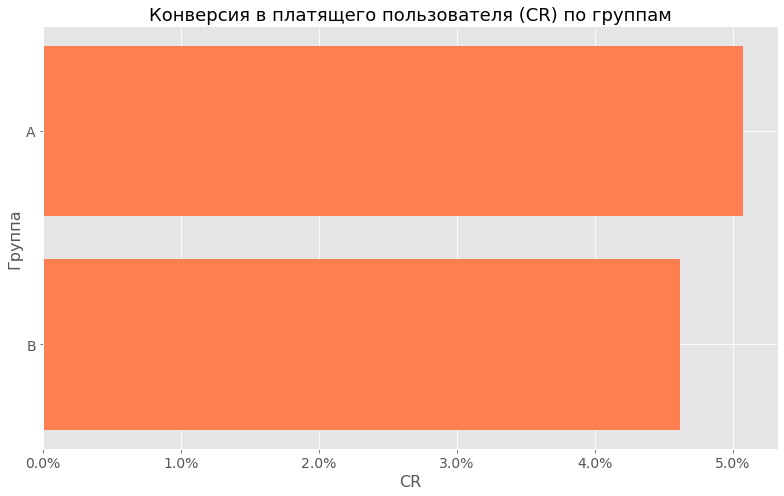

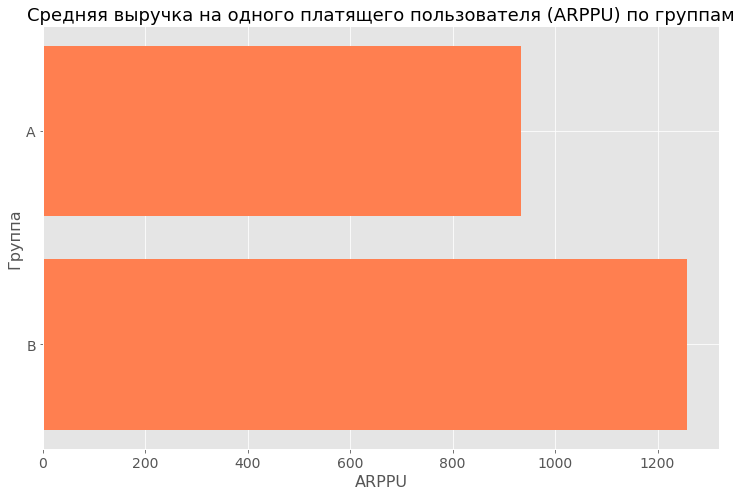

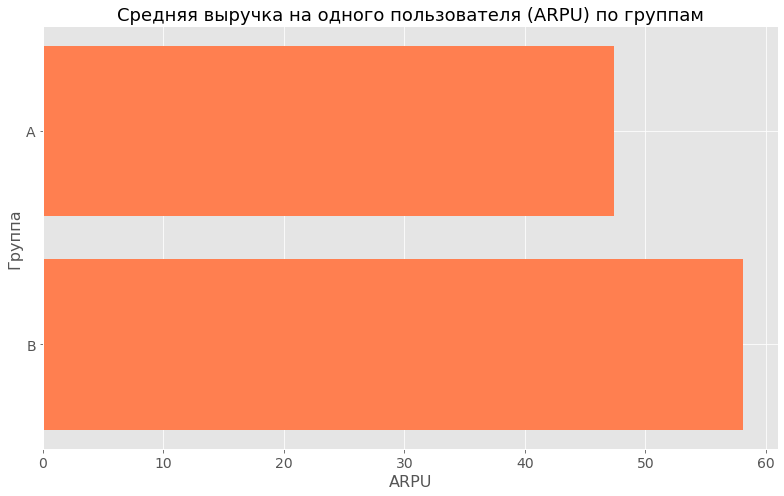

In [33]:
plot_metrics(df_metrics)